# **[HW5] Language Model**
1. DataLoader
2. Model
3. Trainer
4. Generation

이번 실습에서는 RNN기반의 Language Model를 구현해서 텍스트를 직접 생성해보는 실습을 진행해보겠습니다.

- dataset: WikiText2 (https://github.com/pytorch/examples/tree/master/word_language_model/data/wikitext-2)
- model: LSTM




## Import packages

런타임의 유형을 변경해줍니다.

상단 메뉴에서 [런타임]->[런타임유형변경]->[하드웨어가속기]->[GPU]

변경 이후 아래의 cell을 실행 시켰을 때, torch.cuda.is_avialable()이 True가 나와야 합니다.



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
print(torch.__version__)
print(torch.cuda.is_available())

1.10.0+cu111
True


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import tqdm
import os
import random
import time
import datetime

# for reproducibility
random.seed(1234)
np.random.seed(1234)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 1. DataLoader

이전의 실습들에서 사용한것과 마찬가지로, PyTorch style의 dataloader를 먼저 만들어 두겠습니다.

### Dataset

저희가 이번 실습에서 사용할 데이터셋은 Wikipedia에 있는 영문 글들을 가져온 WikiTree dataset입니다.
저희가 불러올 데이터는 가장 작은 WikiTree dataset에서 자주 사용되지 않는 단어나 영어가 아닌 단어들은 <unk>으로 이미 전처리가 되어있습니다.

In [3]:
import urllib
with urllib.request.urlopen('https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/02-intermediate/language_model/data/train.txt') as f:
    data = f.readlines()

In [4]:
print('num_sentence:',len(data))
data[100]

num_sentence: 42068


b" plans that give advertisers discounts for maintaining or increasing ad spending have become permanent <unk> at the news <unk> and underscore the fierce competition between newsweek time warner inc. 's time magazine and <unk> b. <unk> 's u.s. news & world report \n"

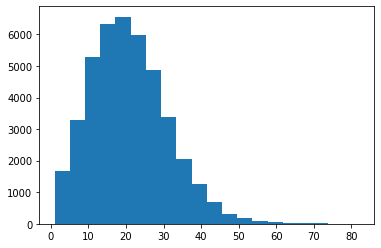

In [5]:
seq_length_list = []
for line in data:
    seq_length_list.append(len(line.split()))

counts, bins = np.histogram(seq_length_list, bins=20)
plt.hist(bins[:-1], bins, weights=counts)
plt.show()

데이터에 있는 문장 길이들의 histogram을 볼 때 대부분의 data의 문장 길이가 50에 미치지 못하기 때문에 \\
model에 집어넣을 최대 문장 길이를 50으로 세팅해두도록 하겠습니다.

In [6]:
max_seq_len = 50

### Build Dictionary

먼저 text 데이터를 모델에 넣어주기 위해서는 text에 존재하는 단어들을 index로 변환해주어야 합니다.

이를 위해서는 단어를 index로 변환해주는 word2idx dictionary와 다시 index를 단어로 변환해주는 idx2word dictionary를 만들어야 합니다.


In [7]:
def build_dictionary(data, max_seq_len):
    word2idx = {}
    idx2word = {}
    ## Build Dictionary
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1
    idx2word[0] = '<pad>'
    idx2word[1] = '<unk>'
    idx = 2
    for line in data:
        words = line.decode('utf-8').split()
        words = words[:max_seq_len]        
        ### Build Dictionary to convert word to index and index to word
        ### YOUR CODE HERE (~ 5 lines)
        for word in words:
            if word not in word2idx:
                word2idx[word] = idx
                idx2word[idx] = word
                idx += 1

    return word2idx, idx2word

word2idx, idx2word = build_dictionary(data, max_seq_len)

In [8]:
if len(word2idx) == len(idx2word) == 10000:
    print("Test Passed!")
else:
    raise AssertionError

Test Passed!


### Preprocessing

이제 앞서 만든 dictionary를 이용해서 text로된 데이터셋을 index들로 변환시키겠습니다.

In [9]:
def preprocess(data, word2idx, idx2word, max_seq_len):
    tokens = []
    for line in data:
        words = line.decode('utf-8').split()
        words = words[:max_seq_len]
        ### Convert dataset with tokens
        ### For each line, append <pad> token to match the number of max_seq_len
        ### YOUR CODE HERE (~ 4 lines)
        for word in words:
            tokens.append(word2idx[word])
        tokens += [word2idx['<pad>']] * (max_seq_len - len(words))
      
    return tokens

tokens = preprocess(data, word2idx, idx2word, max_seq_len)

In [10]:
if len(tokens) == 2103400:
    print("Test Passed!")
else:
    raise AssertionError

Test Passed!


이제 전처리된 Token들을 문장 단위의 배열로 변환시켜 두겠습니다.

In [11]:
tokens = np.array(tokens).reshape(-1, max_seq_len)
print(tokens.shape)
tokens[100]

(42068, 50)


array([745,  93, 746, 739, 747, 181, 748, 467, 749, 740, 750, 154, 751,
       752,   1, 160,  32, 753,   1,  48, 754,  32, 755, 756, 757, 728,
       555, 758,  99, 119, 555, 733,  48,   1, 759,   1, 119, 237, 753,
       230, 760, 347,   0,   0,   0,   0,   0,   0,   0,   0])

### DataLoader

이제 전처리된 dataset을 활용하여 PyTorch style의 dataset과 dataloader를 만들도록 하겠습니다.

Token형태의 데이터를 PyTorch 스타일의 dataset으로 만들 때 주의할 점은, 추후 embedding matrix에서 indexing을 해주기 위해서 각 token이 LongTensor 형태로 정의되어야 한다는 점입니다.

In [12]:
class LMDataset(torch.utils.data.Dataset):
    def __init__(self, tokens):
        super(LMDataset, self).__init__()
        self.PAD = 0
        self.UNK = 1
        self.tokens = tokens
        self._getitem(2)

    def _getitem(self, index):
        X = self.tokens[index]
        y = np.concatenate((X[1:], [self.PAD]))

        X = torch.from_numpy(X).unsqueeze(0).long()
        y = torch.from_numpy(y).unsqueeze(0).long()

        return X, y

    def __getitem__(self, index):
        X = self.tokens[index]
        y = np.concatenate((X[1:], [self.PAD]))

        X = torch.from_numpy(X).long()
        y = torch.from_numpy(y).long()

        return X, y

    def __len__(self):
        return len(self.tokens)

In [13]:
batch_size = 64
dataset = LMDataset(tokens)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(len(dataset))
print(len(dataloader))

42068
658


# 2. Model

이번 section에서는 Language Modeling을 위한 Recurrent Model을 직접 만들어보도록 하겠습니다.

Standard한 Recurrent Neural Network (RNN) model은 vanishing gradient 문제에 취약하기 때문에, 이번 실습에서는 변형된 RNN구조인 LSTM model을 활용하도록 하겠습니다.


### LSTM

LSTM model의 전체적인 구조와 각 gate의 수식은 아래와 같습니다.

![](https://drive.google.com/uc?export=view&id=1n93tpNW55Xl4GxZNcJcbUVRhuNCGH38h)

![](https://drive.google.com/uc?export=view&id=1nH9U5iD9cO6OVVTbrx-LjypRvcWzbOCU)

LSTM의 자세한 동작방식이 궁금하신 분은 아래의 블로그를 참조해주세요.

https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [15]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        # input-gate
        self.Wi = nn.Linear(input_size + hidden_size, hidden_size)
        # forget-gate
        self.Wf = nn.Linear(input_size + hidden_size, hidden_size)
        # gate-gate
        self.Wg = nn.Linear(input_size + hidden_size, hidden_size)
        # output-gate
        self.Wo = nn.Linear(input_size + hidden_size, hidden_size)

        # non-linearity
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x, h_0, c_0):
        """
        Inputs
            input (x): [batch_size, input_size]
            hidden_state (h_0): [batch_size, hidden_size]
            cell_state (c_0): [batch_size, hidden_size]
        Outputs
            next_hidden_state (h_1): [batch_size, hidden_size]
            next_cell_state (c_1): [batch_size, hidden_size]    
        """
        h_1, c_1 = None, None
        input = torch.cat((x, h_0), 1) 
        # Implement LSTM cell as noted above
        ### YOUR CODE HERE (~ 6 lines)
        i = self.sigmoid(self.Wi(input))
        f = self.sigmoid(self.Wf(input))
        g = self.tanh(self.Wg(input))
        o = self.sigmoid(self.Wo(input))
        c_1 = f * c_0 + i * g
        h_1 = o * self.tanh(c_1)

        return h_1,c_1


In [16]:
def test_lstm():
    batch_size = 2
    input_size = 5
    hidden_size = 3

    #torch.manual_seed(1234)
    lstm = LSTMCell(input_size ,hidden_size)
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.constant_(m.weight, 0.1)
            m.bias.data.fill_(0.01)
    lstm.apply(init_weights)

    x = torch.ones(batch_size, input_size) 
    hx = torch.zeros(batch_size, hidden_size) 
    cx = torch.zeros(batch_size, hidden_size)

    hx, cx = lstm(x, hx, cx)
    assert hx.detach().allclose(torch.tensor([[0.1784, 0.1784, 0.1784], 
                                              [0.1784, 0.1784, 0.1784]]), atol=2e-1), \
            f"Output of the hidden state does not match."
    assert cx.detach().allclose(torch.tensor([[0.2936, 0.2936, 0.2936], 
                                              [0.2936, 0.2936, 0.2936]]), atol=2e-1), \
            f"Output of the cell state does not match."

    print("==LSTM cell test passed!==")

test_lstm()

==LSTM cell test passed!==


## Language Model

이제, 위에서 정의한 LSTM Cell을 활용해서 아래와 같은 Langauge Model을 만들어보도록 하겠습니다.


![](https://drive.google.com/uc?export=view&id=1nMAbL-g31nERM44dgohA3k9Vj_92hIh-)

In [17]:
class LanguageModel(nn.Module):
    def __init__(self, input_size=64, hidden_size=64, vocab_size=10000):
        super(LanguageModel, self).__init__()
        
        self.input_layer = nn.Embedding(vocab_size, input_size)
        self.hidden_layer = LSTMCell(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, vocab_size)


    def forward(self, x, hx, cx, predict=False):
        """
        Inputs
            input (x): [batch_size]
            hidden_state (h_0): [batch_size, hidden_size]
            cell_state (c_0): [batch_size, hidden_size]
            predict: whether to predict and sample the next word
        Outputs
            output (ox): [batch_size, hidden_size]
            next_hidden_state (h_1): [batch_size, hidden_size]
            next_cell_state (c_1): [batch_size, hidden_size]    
        """
        x = self.input_layer(x)
        hx, cx = self.hidden_layer(x, hx, cx)
        ox = self.output_layer(hx)

        if predict == True:
            probs = F.softmax(ox, dim=1)
            # torch distribution allows sampling operation
            # see https://pytorch.org/docs/stable/distributions.html
            dist = torch.distributions.Categorical(probs)
            ox = dist.sample()

        return ox, hx, cx  

# 3. Trainer

자 이제 위에서 구현한 dataloader와 langauge model을 활용해서 모델의 학습을 진행해보도록 하겠습니다.


In [20]:
class Trainer():
    def __init__(self, 
                 word2idx, 
                 idx2word,
                 dataloader, 
                 model, 
                 criterion,
                 optimizer, 
                 device):
        """
        dataloader: dataloader
        model: langauge model
        criterion: loss function to evaluate the model (e.g., BCE Loss)
        optimizer: optimizer for model
        """
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.dataloader = dataloader
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        
    def train(self, epochs = 1):
        self.model.to(self.device)
        start_time = time.time()
        for epoch in range(epochs):
            losses = []
            for iter, (x_batch, y_batch) in tqdm.tqdm(enumerate(self.dataloader)):
                self.model.train()
                
                batch_size, max_seq_len = x_batch.shape
                x_batch = x_batch.to(self.device)
                y_batch = y_batch.to(self.device)

                # initial hidden-states
                hx = torch.zeros(batch_size, hidden_size).to(self.device)
                cx = torch.zeros(batch_size, hidden_size).to(self.device)

                # Implement LSTM operation
                ox_batch = []
                # Get output logits for each time sequence and append to the list, ox_batch
                # YOUR CODE HERE (~ 4 lines)
                for s_idx in range(max_seq_len):
                    x = x_batch[:, s_idx]
                    ox, hx, cx = self.model(x, hx, cx)
                    ox_batch.append(ox)

                # outputs are ordered by the time sequence
                ox_batch = torch.cat(ox_batch).reshape(max_seq_len, batch_size, -1)
                ox_batch = ox_batch.permute(1,0,2).reshape(batch_size*max_seq_len, -1)
                y_batch = y_batch.reshape(-1)

                self.model.zero_grad()
                loss = self.criterion(ox_batch, y_batch)
                loss.backward()
                self.optimizer.step()
                losses.append(loss.item())

            end_time = time.time() - start_time
            end_time = str(datetime.timedelta(seconds=end_time))[:-7]
            print('Time [%s], Epoch [%d/%d], loss: %.4f'
                  % (end_time, epoch+1, epochs, np.mean(losses)))
            if epoch % 5 == 0:
                generated_sentences = self.test()
                print('[Generated Sentences]')
                for sentence in generated_sentences:
                    print(sentence)
            
    def test(self):
        # Test model to genereate the sentences
        self.model.eval()
        num_sentence = 5
        max_seq_len = 50

        # initial hidden-states
        outs = []
        x = torch.randint(0, 10000, (num_sentence,)).to(self.device)
        hx = torch.zeros(num_sentence, hidden_size).to(self.device)
        cx = torch.zeros(num_sentence, hidden_size).to(self.device)

        outs.append(x)
        with torch.no_grad():
            for s_idx in range(max_seq_len-1):
                x, hx, cx = self.model(x, hx, cx, predict=True)
                outs.append(x)
        outs = torch.cat(outs).reshape(max_seq_len, num_sentence)
        outs = outs.permute(1, 0)
        outs = outs.detach().cpu().numpy()

        sentences = []
        for out in outs:
            sentence = []
            for token_idx in out:
                word = self.idx2word[token_idx]
                sentence.append(word)
            sentences.append(sentence)
       
        return sentences

In [21]:
lr = 1e-2
input_size = 128
hidden_size = 128
batch_size = 256

dataset = LMDataset(tokens)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = LanguageModel(input_size=input_size, hidden_size=hidden_size)
# NOTE: you should use ignore_index to ignore the loss from predicting the <PAD> token
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=lr)
device = torch.device('cuda')

trainer = Trainer(word2idx = word2idx,
                  idx2word = idx2word,
                  dataloader=dataloader, 
                  model = model,
                  criterion=criterion,
                  optimizer = optimizer,
                  device=device)

trainer.train(epochs=50)

165it [00:36,  4.48it/s]


Time [0:00:36], Epoch [1/50], loss: 6.1005
[Generated Sentences]
['preference', 'is', 'sagged', 'at', 'N', 'billion', 'yen', 'to', 'be', 'or', 'the', 'year-ago', 'period', 'at', 'N', 'N', 'point', 'to', 'close', 'against', '<unk>', 'the', 'lucrative', 'cease-fire', 'with', 'properties', 'to', '<unk>', 'the', 'plant', 'would', "n't", '<unk>', 'the', 'white', 'house', 'budget', 'teacher', 'said', 'stephen', 'british', 'executive', 'officer', 'of', 'black', 'california', 'thatcher', "'s", 'author', 'is']
['earnings', 'up', 'about', 'N', 'N', 'billion', 'a', 'movement', 'mass.', 'and', 'lower', 'international', 'work', 'bond', 'have', 'a', 'lot', 'as', 'the', 'food', 'african', 'program', 'trading', 'had', 'object', 'the', 'secondary', 'weekend', 'in', 'fashionable', 'majority', 'of', 't.', 'produced', 'equity', 'years', 'by', 'wolf', 'stocks', 'came', 'from', 'the', 'first', 'quarter', 'for', 'the', 'fierce', 'and', 'plastic', 'sustained']
['hunting', 'bounced', 'have', 'true', 'a', 'coop

165it [00:36,  4.50it/s]


Time [0:01:13], Epoch [2/50], loss: 5.2211


165it [00:36,  4.49it/s]


Time [0:01:50], Epoch [3/50], loss: 4.9075


165it [00:36,  4.50it/s]


Time [0:02:27], Epoch [4/50], loss: 4.7044


165it [00:36,  4.49it/s]


Time [0:03:03], Epoch [5/50], loss: 4.5492


165it [00:36,  4.50it/s]


Time [0:03:40], Epoch [6/50], loss: 4.4231
[Generated Sentences]
['weakened', 'in', 'citizen', 'the', 'talks', 'might', "n't", 'mean', 'we', 'get', 'a', 'breakdown', 'that', 'money', 'should', 'the', 'team', 'far', '<unk>', 'their', 'hurdles', 'i', "'m", 'going', 'to', 'sue', 'concerns', 'or', 'areas', 'of', 'a', '<unk>', 'couple', 'with', 'racing', 'by', 'california', 'appropriations', 'committees', 'not', 'vision', 'of', 'their', 'fear', 'of', 'items', 'such', 'at', 'closely', 'held']
['with', 'other', 'difficult', 'circumstances', 'yesterday', 'that', 'in', 'minneapolis', 'he', 'has', 'put', 'the', 'main', 'irony', 'in', 'his', 'own', 'aoun', 'regulators', 'without', 'sending', 'a', '<unk>', '<unk>', 'over', 'the', 'economy', 'in', 'the', 'world', "'s", 'atmosphere', 'of', 'environmental', 'cases', 'to', 'hide', 'but', 'and', 'is', 'investment-grade', 'interest', 'rates', 'in', 'the', 'period', 'when', 'a', 'registered', 'in']
['refused', 'to', 'payment', 'of', '$', 'N', 'million', 

165it [00:36,  4.49it/s]


Time [0:04:17], Epoch [7/50], loss: 4.3159


165it [00:36,  4.48it/s]


Time [0:04:54], Epoch [8/50], loss: 4.2229


165it [00:36,  4.50it/s]


Time [0:05:30], Epoch [9/50], loss: 4.1433


165it [00:36,  4.49it/s]


Time [0:06:07], Epoch [10/50], loss: 4.0740


165it [00:36,  4.50it/s]


Time [0:06:44], Epoch [11/50], loss: 4.0102
[Generated Sentences]
['conasupo', 'facilities', 'they', 'are', 'currently', 'about', 'five', 'million', 'to', 'N', 'magazines', 'have', "n't", 'run', 'with', 'leveraged', 'buy-outs', 'were', 'slow', 'to', 'have', 'to', 'invest', 'in', 'treating', 'takeovers', 'in', 'the', 'industry', 'industry', 'with', 'a', 'plant', 'concern', 'have', 'led', 'the', 'biggest', 'insurer', 'is', 'subject', 'to', 'measure', 'murphy', 'brown', 'has', 'acquired', 'estimates', 'exceeding', 'a']
['locally', 'elected', 'governments', 'suppliers', 'a', 'friend', 'in', 'shanghai', 'states', 'conducting', '<unk>', 'in', 'the', 'west', 'usually', 'in', 'N', 'years', 'of', 'rising', '<unk>', 'a', '<unk>', 'industry', 'said', '<unk>', 'to', 'make', 'certain', 'of', '<unk>', '<unk>', 'scores', 'have', '<unk>', 'from', 'oklahoma', 'officials', 'that', 'trade', 'that', 'story', 'represents', 'a', 'resolution', 'that', 'he', 'will', 'explain', 'over']
['sciences', 'said', 'th

165it [00:36,  4.50it/s]


Time [0:07:21], Epoch [12/50], loss: 3.9532


165it [00:36,  4.50it/s]


Time [0:07:57], Epoch [13/50], loss: 3.9039


165it [00:36,  4.49it/s]


Time [0:08:34], Epoch [14/50], loss: 3.8578


165it [00:36,  4.50it/s]


Time [0:09:11], Epoch [15/50], loss: 3.8153


165it [00:36,  4.50it/s]


Time [0:09:47], Epoch [16/50], loss: 3.7762
[Generated Sentences]
['hud', 'said', 'these', 'predicted', 'they', 'were', "n't", 'known', 'but', 'we', 'are', 'always', 'going', 'to', 'speak', 'out', 'detailed', 'sanctions', 'into', 'such', 'members', 'and', 'by', 'the', 'fbi', "'s", 'no.', 'N', '<unk>', 'rally', 'sunday', 'in', 'a', 'such', 'money', 'traders', 'will', 'now', 'open', 'the', 'offices', 'of', '<unk>', 'conn', 'on', 'serving', 'and', 'broken', '<unk>', 'with']
['sure', 'prices', 'extended', 'periods', 'despite', 'its', 'adrs', 'have', 'trimmed', 'below', 'changes', 'in', 'the', 'month', 'outstanding', 'has', 'weakened', 'in', 'the', 'affected', 'service', 'group', 'but', 'their', 'increases', 'subordinates', 'have', 'plagued', 'retail', 'reserves', 'by', '<unk>', 'last', 'week', 'on', 'taxes', 'because', 'by', 'computers', 'for', 'the', 'prestigious', 'rockefeller', 'university', 'of', 'the', 'maryland', 'maker', 'of', '<unk>']
['time', 'a', 'bipartisan', 'of', 'complaint', 

165it [00:36,  4.50it/s]


Time [0:10:24], Epoch [17/50], loss: 3.7417


165it [00:36,  4.49it/s]


Time [0:11:01], Epoch [18/50], loss: 3.7092


165it [00:36,  4.50it/s]


Time [0:11:38], Epoch [19/50], loss: 3.6797


165it [00:36,  4.50it/s]


Time [0:12:14], Epoch [20/50], loss: 3.6507


165it [00:36,  4.49it/s]


Time [0:12:51], Epoch [21/50], loss: 3.6266
[Generated Sentences]
['towel', 'with', 'new', '<unk>', 'and', 'trust', 'said', 'but', 'it', "'s", '<unk>', 'about', 'property', 'and', 'rate', 'boost', 'to', 'be', 'available', 'to', 'buy', 'shares', 'of', 'N', 'N', 'stake', 'in', 'the', 'benchmark', '30-year', 'bond', 'that', 'was', 'an', 'easy', 'more', 'than', 'february', 'stock', 'prices', 'have', 'had', 'strong', 'five', 'years', 'mr.', '<unk>', 'said', 'it', 'once']
['barring', '<unk>', 'is', 'very', 'considerable', 'enough', 'to', 'some', 'estimate', 'that', 'need', 'to', 'avoid', 'closer', 'only', 'in', 'this', 'time', 'compared', 'with', 'delays', 'but', 'new', 'york', "'s", 'state-owned', 'sept.', 'N', 'slightly', 'remained', 'the', 'first', 'half', 'of', 'N', 'to', 'N', 'mr.', 'guber', 'and', 'recently', 'he', 'put', 'in', 'nature', 'to', 'survey', 'looked', 'to', 'load']
['deserves', 'except', 'for', '<unk>', 'dunn', 'has', 'offered', '$', 'N', 'asked', 'a', '<unk>', '<unk>', 'an

165it [00:36,  4.50it/s]


Time [0:13:28], Epoch [22/50], loss: 3.6026


165it [00:36,  4.50it/s]


Time [0:14:04], Epoch [23/50], loss: 3.5797


165it [00:36,  4.51it/s]


Time [0:14:41], Epoch [24/50], loss: 3.5592


165it [00:36,  4.49it/s]


Time [0:15:18], Epoch [25/50], loss: 3.5402


165it [00:36,  4.51it/s]


Time [0:15:54], Epoch [26/50], loss: 3.5238
[Generated Sentences]
['quantities', 'when', 'you', 'i', 'think', 'you', 'have', 'a', 'passion', 'he', 'recalls', 'but', 'president', 'bush', 'veto', 'power', 'after', 'payments', 'until', 'early', 'this', 'month', 'amid', 'the', 'studies', 'it', 'can', 'be', 'included', 'in', 'a', 'secret', 'position', 'over', 'declaring', 'by', 'lawmakers', 'by', 'diversifying', 'into', 'an', 'oregon', '<unk>', 'pot', 'trading', 'for', 'hong', 'kong', 'work', 'habits']
['security', 'ticket', 'splitting', 'along', 'to', 'invest', 'a', 'new', 'facility', 'and', 'used', 'to', 'cut', 'costs', 'and', 'boost', 'amounts', 'of', 'money', 'without', 'proceedings', 'differently', 'and', 'will', 'repeat', 'the', 'bellsouth', 'idea', 'too', 'soon', 'for', 'quick', 'construction', 'abroad', 'mostly', 'through', 'the', 'status', 'of', 'the', 'packaging', 'industry', 'may', 'not', 'be', 'in', '<unk>', 'and', 'moved', 'around']
['nomination', 'of', 'these', 'days', 'machin

165it [00:36,  4.50it/s]


Time [0:16:31], Epoch [27/50], loss: 3.5064


165it [00:36,  4.49it/s]


Time [0:17:08], Epoch [28/50], loss: 3.4901


165it [00:36,  4.50it/s]


Time [0:17:45], Epoch [29/50], loss: 3.4734


165it [00:36,  4.51it/s]


Time [0:18:21], Epoch [30/50], loss: 3.4624


165it [00:36,  4.51it/s]


Time [0:18:58], Epoch [31/50], loss: 3.4495
[Generated Sentences]
['investing', 'groups', 'watched', 'the', 'fundamentals', 'against', 'mrs.', '<unk>', 'says', 'most', 'survived', 'is', 'among', 'the', 'core', 'thrifts', 'and', 'will', 'remain', 'on', 'foreign', 'loans', 'to', 'less-developed', 'countries', 'from', '<unk>', 'industries', 'and', 'another', 'u.k.', 'image', 'advertising', 'firm', 'in', 'america', 'which', 'met', 'separately', 'announced', 'and', 'sold', 'to', 'the', 'swelling', 'balance', 'of', 'orders', 'for', 'use']
['contributed', 'shoulder', 'granting', 'disruptions', 'started', 'last', 'hotel', 'at', 'britain', 'of', 'dallas', 'whose', 'debt', 'households', 'established', 'in', 'ual', 'corp.', 'which', '<unk>', 'corporate', 'moves', 'are', 'eager', 'to', 'see', 'this', 'weather', '<unk>', 'later', 'than', 'the', '<unk>', '<unk>', 'of', 'the', 'defense', 'department', 'plans', 'according', 'to', 'the', 'transaction', 'said', 'they', 'agreed', 'along', 'with', 'that',

165it [00:36,  4.49it/s]


Time [0:19:35], Epoch [32/50], loss: 3.4392


165it [00:36,  4.50it/s]


Time [0:20:11], Epoch [33/50], loss: 3.4247


165it [00:36,  4.50it/s]


Time [0:20:48], Epoch [34/50], loss: 3.4144


165it [00:36,  4.51it/s]


Time [0:21:25], Epoch [35/50], loss: 3.4060


165it [00:36,  4.51it/s]


Time [0:22:01], Epoch [36/50], loss: 3.3955
[Generated Sentences]
['acts', 'rebel', 'cutbacks', 'backed', 'crossland', 'properties', 'N', 'to', 'a', 'record', 'N', 'N', 'increase', 'in', 'revenue', 'in', 'the', 'venture', "'s", 'advertising', 'and', 'monetary', 'reserves', 'before', 'a', 'two-year', 'date', 'of', 'carbon', 'dioxide', 'as', 'a', 'previously', 'offer', 'exercised', 'for', 'the', 'fourth', 'quarter', 'while', 'remic', 'the', 'company', "'s", 'registered', 'immediate', 'outlook', 'at', 'all', 'what']
['unpopular', 'taxation', 'due', 'to', 'more', 'than', 'N', 'N', 'to', 'buy', 'N', 'boxes', 'and', '<unk>', 'agents', 'use', 'of', 'the', 'world', "'s", 'largest', 'no.', 'N', 'national', 'mortgage', 'association', 'last', 'week', 'miami-based', 'senior', 'notes', 'quebecor', 'of', 'swiss', 'debt', 'programs', 'it', '<unk>', 'all', 'of', 'their', 'rise', 'next', 'year', 'that', 'up', 'again', 'as', 'an', 'afternoon']
['team', 'returned', 'strip', '<unk>', 'the', 'assistant', '

165it [00:36,  4.52it/s]


Time [0:22:38], Epoch [37/50], loss: 3.3900


165it [00:36,  4.50it/s]


Time [0:23:14], Epoch [38/50], loss: 3.3852


165it [00:36,  4.50it/s]


Time [0:23:51], Epoch [39/50], loss: 3.3727


165it [00:36,  4.51it/s]


Time [0:24:28], Epoch [40/50], loss: 3.3658


165it [00:36,  4.51it/s]


Time [0:25:04], Epoch [41/50], loss: 3.3599
[Generated Sentences]
['sustained', 'altered', 'a', 'veteran', 'executive', 'who', 'funded', 'by', 'hurricane', 'hugo', 'and', 'the', 'greedy', 'u.s.', 'unit', 'might', 'be', 'completed', 'a', 'N', 'N', 'per-share', 'earnings', 'per', 'share', 'in', 'its', 'institutional', 'announcement', 'and', 'had', 'arranged', 'appointed', '<unk>', '&', 'dodge', '<unk>', 'ltd.', 'said', 'it', 'had', 'only', 'minor', 'damage', 'the', 'markets', 'estimated', 'profits', 'and', 'restructurings']
['disagreement', 'multimillion-dollar', 'disagreed', 'sweden', 'N', 'N', 'N', 'p.m.', 'est', 'on', 'pbs', 'thomas', 'hart', 'benton', 'cargo', 'henry', '&', '<unk>', 'inc', 'japan', '$', 'N', 'million', 'of', 'N', 'N', 'bonds', 'priced', 'at', 'N', 'to', 'yield', 'N', 'N', 'while', 'the', '<unk>', 'ratio', 'of', 'N', 'missiles', 'by', 'eliminating', 'data', 'on', 'electronic', 'products', 'manufacturer', 'through', 'california']
['capped', 'that', 'is', 'concentrated'

165it [00:36,  4.52it/s]


Time [0:25:41], Epoch [42/50], loss: 3.3508


165it [00:36,  4.50it/s]


Time [0:26:18], Epoch [43/50], loss: 3.3461


165it [00:36,  4.51it/s]


Time [0:26:54], Epoch [44/50], loss: 3.3410


165it [00:36,  4.51it/s]


Time [0:27:31], Epoch [45/50], loss: 3.3342


165it [00:36,  4.49it/s]


Time [0:28:08], Epoch [46/50], loss: 3.3303
[Generated Sentences]
['liquid', 'posts', 'soon', 'generally', 'does', "n't", 'expect', 'bellsouth', 'chairman', 'john', '<unk>', 'a', 'new', 'group', 'in', 'a', '<unk>', '<unk>', 'in', 'chicago', 'a', '<unk>', 'manufacturer', 'called', '<unk>', 'the', 'preamble', 'to', 'a', 'new', '<unk>', 'ca', 'at', 'the', 'same', 'one', 'might', 'select', 'their', 'conclusions', 'on', 'the', 'federal', 'trade', 'commission', 'in', 'the', 'new', 'zealand', 'and']
['investigating', 'jupiter', 'together', 'mary', 'farrell', 'lawrence', '<unk>', 'fazio', 'fleet', 'of', 'lawsuits', 'for', 'years', 'and', 'to', 'white', '<unk>', 'the', 'performance', 'of', 'the', '<unk>', 'and', 'in', '<unk>', 'n.y.', 'and', 'a', 'dozen', 'of', 'the', 'justice', 'department', 'of', 'the', 'president', "'s", '<unk>', 'drug', '<unk>', 'and', '<unk>', 'will', 'jolt', '<unk>', 'and', '<unk>', 'both', '<unk>', 'and']
['colombian', 'lawsuits', 'with', 'the', 'recent', 'crash', 'prote

165it [00:36,  4.50it/s]


Time [0:28:44], Epoch [47/50], loss: 3.3253


165it [00:36,  4.50it/s]


Time [0:29:21], Epoch [48/50], loss: 3.3224


165it [00:36,  4.51it/s]


Time [0:29:58], Epoch [49/50], loss: 3.3181


165it [00:36,  4.50it/s]

Time [0:30:34], Epoch [50/50], loss: 3.3143


생성된 텍스트의 퀄리티는 어떤가요? 

앞으로 딥러닝 강의가 끝나면 자연어처리 강좌에서 본격텍스트 처리에 적합한 전처리, 모델구조, 학습 trick들을 배우시게 될것입니다.

# References

1. https://github.com/pytorch/examples/tree/master/word_language_model
2. https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/02-intermediate/language_model